### Required Libraries


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sn
import skimage.io
import os.path
import tqdm
import glob
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam


## Data Loading and Label Extraction
    In this section, we load image data from a specified directory and extract class labels based on the folder structure. We aim to exclude images that are located in folders containing "GT" in their path, as these are not needed for training.

In [3]:
root_dir  =  Path('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

filepaths = [str(path) for path in root_dir.glob("**/*.png") if "GT" not in str(path)]
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Class')

df = pd.DataFrame({'Filepath': filepaths, 'Class': labels})

## Printing labels and filepaths

In [4]:
labels

0       Hourse Mackerel
1       Hourse Mackerel
2       Hourse Mackerel
3       Hourse Mackerel
4       Hourse Mackerel
             ...       
8995      Red Sea Bream
8996      Red Sea Bream
8997      Red Sea Bream
8998      Red Sea Bream
8999      Red Sea Bream
Name: Class, Length: 9000, dtype: object

In [5]:
filepaths


0       /kaggle/input/a-large-scale-fish-dataset/Fish_...
1       /kaggle/input/a-large-scale-fish-dataset/Fish_...
2       /kaggle/input/a-large-scale-fish-dataset/Fish_...
3       /kaggle/input/a-large-scale-fish-dataset/Fish_...
4       /kaggle/input/a-large-scale-fish-dataset/Fish_...
                              ...                        
8995    /kaggle/input/a-large-scale-fish-dataset/Fish_...
8996    /kaggle/input/a-large-scale-fish-dataset/Fish_...
8997    /kaggle/input/a-large-scale-fish-dataset/Fish_...
8998    /kaggle/input/a-large-scale-fish-dataset/Fish_...
8999    /kaggle/input/a-large-scale-fish-dataset/Fish_...
Name: Filepath, Length: 9000, dtype: object

## Analyzing Class Distribution

In [6]:
labels.value_counts()

Class
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

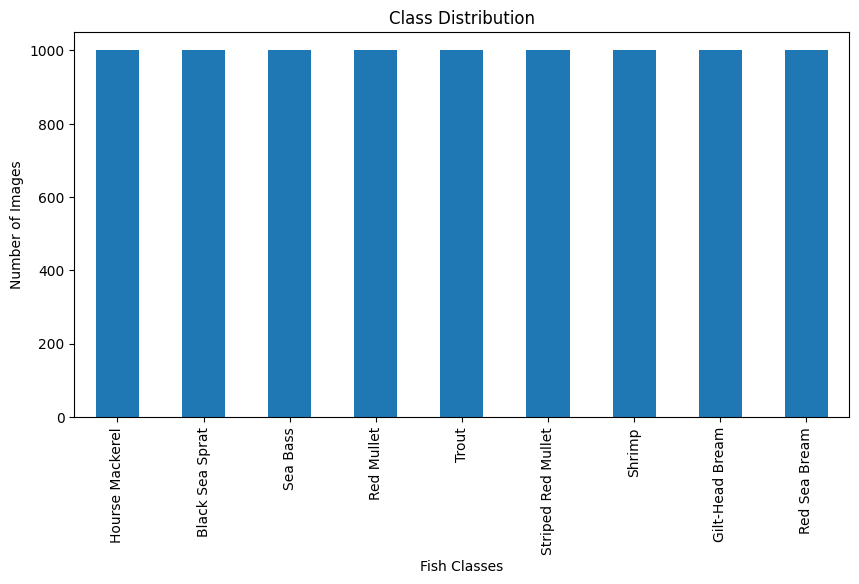

In [10]:
df['Class'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Class Distribution')
plt.xlabel('Fish Classes')
plt.ylabel('Number of Images')
plt.show()

## Checking Image Resolution 

In [7]:
df['resolution'] = df['Filepath'].apply(lambda x: Image.open(x).size)  # Görsel boyutunu kontrol etmek için
print(df['resolution'].describe())

count           9000
unique             1
top       (590, 445)
freq            9000
Name: resolution, dtype: object


## Visualizing Sample Images by Class

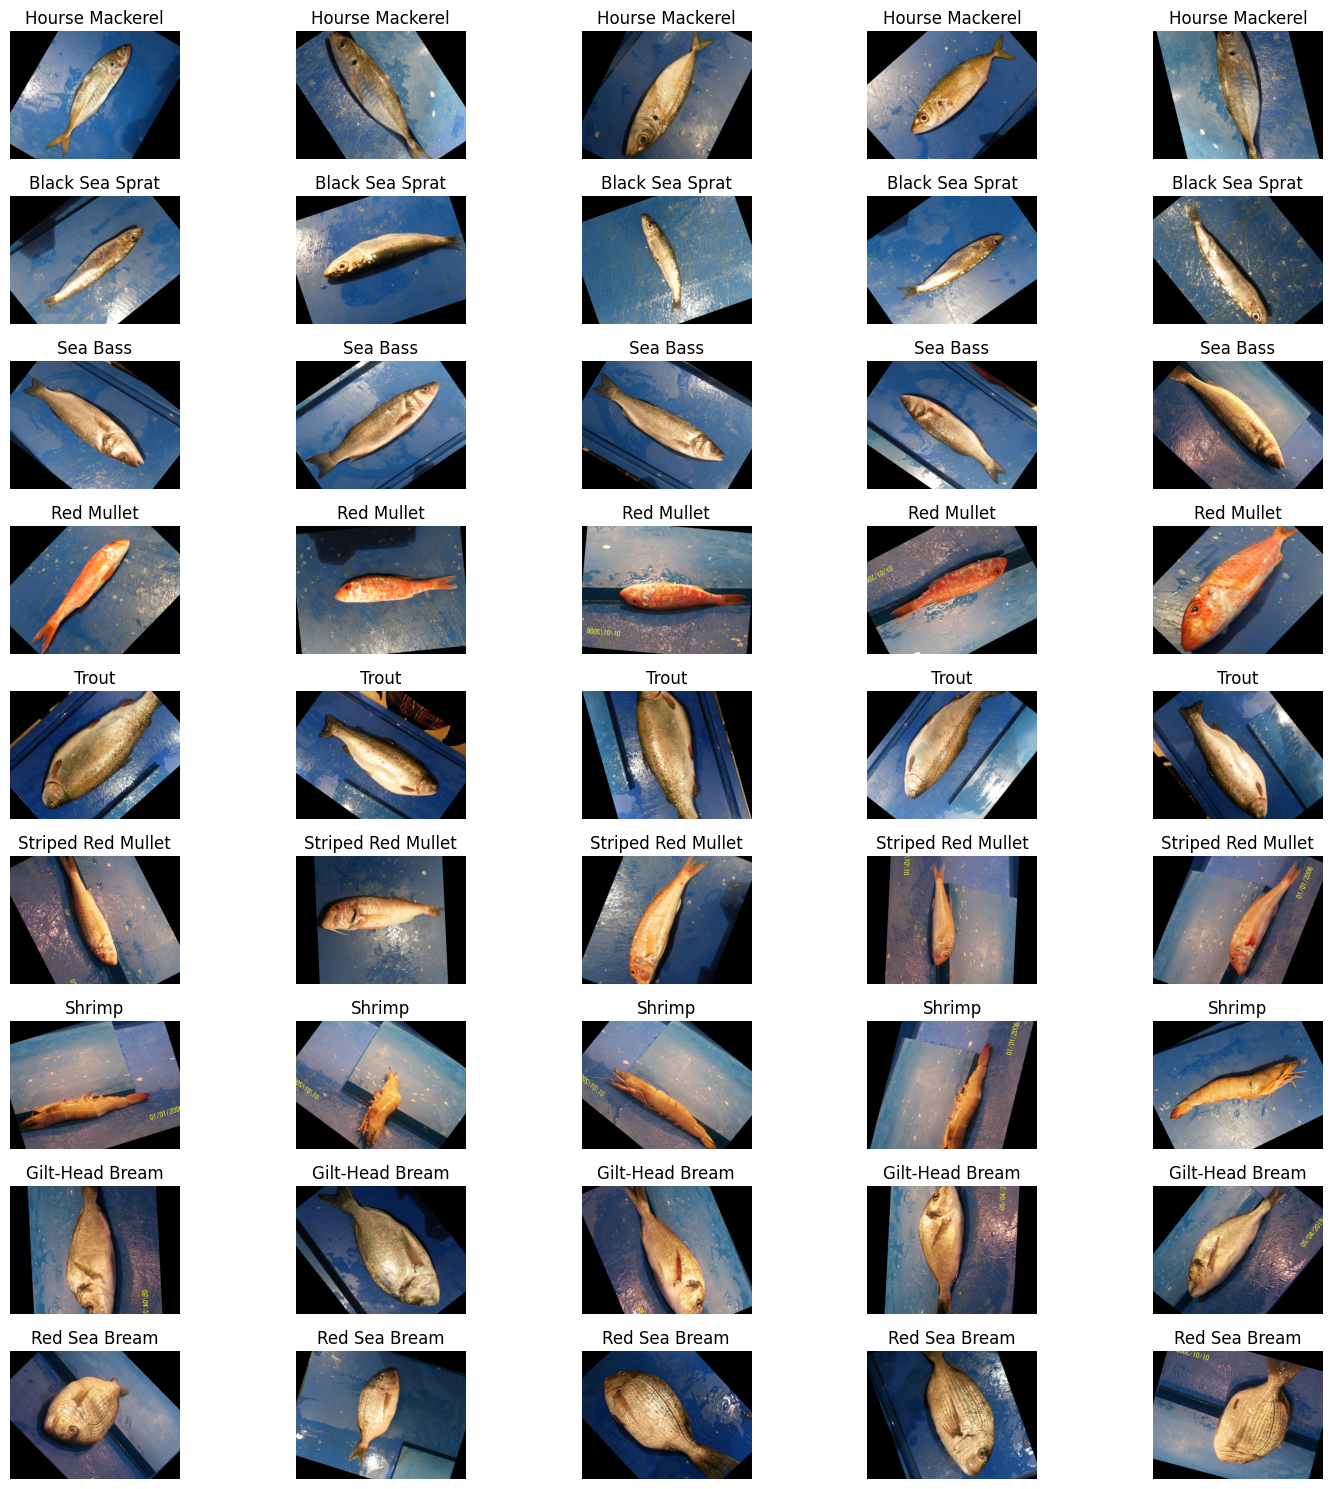

In [8]:
def plot_sample_images(df, num_samples=5):
    fig, axes = plt.subplots(len(df['Class'].unique()), num_samples, figsize=(15, 15))
    for i, label in enumerate(df['Class'].unique()):
        sample_images = df[df['Class'] == label].sample(num_samples)
        for j, img_path in enumerate(sample_images['Filepath']):
            img = Image.open(img_path)
            axes[i, j].imshow(np.array(img))
            axes[i, j].set_title(label)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(df)

## Plotting Image Histograms

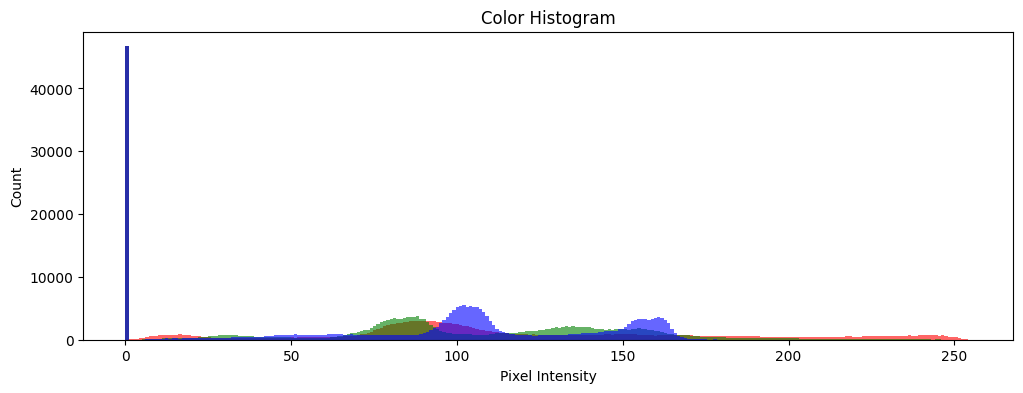

In [9]:
def plot_image_histogram(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)

    plt.figure(figsize=(12, 4))
    for i, color in enumerate(['red', 'green', 'blue']):
        plt.hist(img_array[:, :, i].flatten(), bins=256, color=color,alpha= 0.6)
    plt.title("Color Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Count")
    plt.show()

plot_image_histogram(df['Filepath'].sample(1).values[0])

## Loading and Preprocessing Images
    In this section, we define a function to load and preprocess images from file paths. The goal is to resize each image to a standard size and convert it into a NumPy array, which can then be fed into the machine learning model. We also create arrays X and y to hold the processed images and their corresponding class labels.

In [12]:
img_size = (256, 256)

def load_and_preprocess_image(filepath):
    
    img = load_img(filepath, target_size=img_size)  
    img_array = img_to_array(img)  
    return img_array

X = np.array([load_and_preprocess_image(fp) for fp in df['Filepath']])
y = np.array(df['Class'].tolist())  



## Showing an sample 

In [13]:
X[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

## Checking the Shape of Feature and Label Arrays

In [14]:
print(X.shape)
print(y.shape)

(9000, 256, 256, 3)
(9000,)


## Splitting the Dataset into Training, Validation, and Test Sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


In [16]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(7200, 256, 256, 3)
(7200,)
(900, 256, 256, 3)
(900,)
(900, 256, 256, 3)
(900,)


In [18]:
y_train[0]

'Hourse Mackerel'

## Reshaping and Normalizing Image Data

In [20]:
X_train = X_train.reshape((X_train.shape[0], 256 * 256 * 3)).astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], 256 * 256 * 3)).astype('float32') / 255
X_val = X_val.reshape((X_val.shape[0], 256 * 256 * 3)).astype('float32') / 255

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(7200, 196608)
(900, 196608)
(900, 196608)


## Encoding and One-Hot Encoding the Labels

In [21]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_val_enc = le.transform(y_val)


y_train_cat = to_categorical(y_train_enc, num_classes=9)
y_test_cat = to_categorical(y_test_enc, num_classes=9)
y_val_cat = to_categorical(y_val_enc, num_classes=9)



In [22]:
print(y_train_enc[0])
print(y_test_enc[0])
print(y_val_enc[0])

2
1
5


In [23]:
print(y_train_cat[0])
print(y_test_cat[0])
print(y_val_cat[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [24]:
print(f"X_train: {len(X_train)}")
print(f"X_val: {len(X_val)}")
print(f"y_train: {len(y_train)}")
print(f"y_val: {len(y_val)}")

X_train: 7200
X_val: 900
y_train: 7200
y_val: 900


## Building the Neural Network Model

In [27]:
model = Sequential()

model.add(Input(shape=(256 * 256 * 3,)))
model.add(Flatten())

model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))  

model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.001)))  
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax')) 

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=5)

## Training the Neural Network Model

In [31]:
history = model.fit(
    X_train,
    y_train_cat,
    epochs=20,
    validation_data=(X_val, y_val_cat),
    callbacks = early_stopping
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 198s 858ms/step - accuracy: 0.1293 - loss: 3.9669 - val_accuracy: 0.2478 - val_loss: 2.8243
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 187s 831ms/step - accuracy: 0.1481 - loss: 3.6614 - val_accuracy: 0.3656 - val_loss: 2.5772
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 210s 935ms/step - accuracy: 0.1723 - loss: 3.3504 - val_accuracy: 0.4111 - val_loss: 2.4801
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 193s 857ms/step - accuracy: 0.1952 - loss: 3.2319 - val_accuracy: 0.4356 - val_loss: 2.4176
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 192s 852ms/step - accuracy: 0.2078 - loss: 3.0767 - val_accuracy: 0.4267 - val_loss: 2.3674
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 188s 836ms/step - accuracy: 0.2235 - loss: 2.9480 - val_accuracy: 0.4867 - val_loss: 2.2551
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 193s 856ms/step - accuracy: 0.2356 - loss: 2.8605 - val_accuracy: 0.4533 - val_loss: 2.2305
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 188s 837ms/step - accuracy: 0.2510 -

## Plotting Training and Validation Metrics

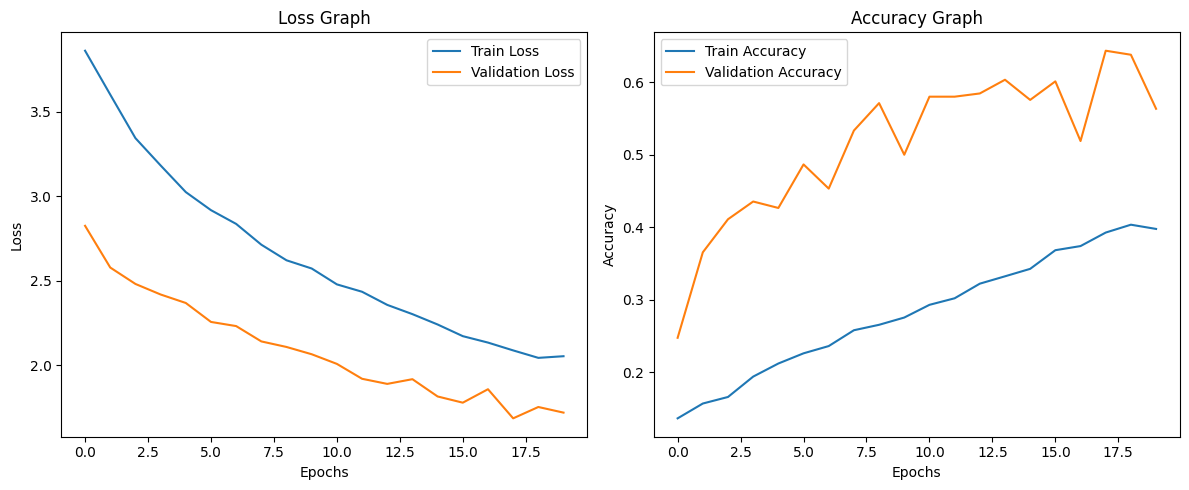

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


## Evaluating the Model on Test Data

In [37]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 1.6644231081008911
Test Accuracy: 0.5844444632530212
